In [32]:
from numpyro import optim
import numpyro

import jax.numpy as jnp
import jax
import yaml
import os
import sys


sys.path.insert(1,'..')
import loader
import setup

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:

dataloader = loader.IBLDataLoader(
    setup.params,eids=setup.good_eids
)

xs,ys,rs,cs = dataloader.load_train_data()

loading session:  e2b845a1-e313-4a08-bc61-a5f662ed295e
loading session data:  e2b845a1-e313-4a08-bc61-a5f662ed295e
loading session:  2bdf206a-820f-402f-920a-9e86cd5388a4
loading session data:  2bdf206a-820f-402f-920a-9e86cd5388a4
loading session:  5dcee0eb-b34d-4652-acc3-d10afc6eae68
loading session data:  5dcee0eb-b34d-4652-acc3-d10afc6eae68
loading session:  c7bf2d49-4937-4597-b307-9f39cb1c7b16


local md5 mismatch on dataset: cortexlab/Subjects/KS074/2021-11-22/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy
local md5 mismatch on dataset: cortexlab/Subjects/KS074/2021-11-22/001/alf/probe00/pykilosort/channels.mlapdv.npy
../data/2022_Q2_IBL_et_al_RepeatedSite/cortexlab/Subjects/KS074/2021-11-22/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 50.1kB/s]
../data/2022_Q2_IBL_et_al_RepeatedSite/cortexlab/Subjects/KS074/2021-11-22/001/alf/probe00/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 95.1kB/s]
local md5 mismatch on dataset: cortexlab/Subjects/KS074/2021-11-22/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy
local md5 mismatch on dataset: cortexlab/Subjects/KS074/2021-11-22/001/alf/probe00/pykilosort/channels.mlapdv.npy
../data/2022_Q2_IBL_et_al_RepeatedSite/cortexlab/Subjects/KS074/2021-11-22/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_201

loading session data:  c7bf2d49-4937-4597-b307-9f39cb1c7b16
loading session:  824cf03d-4012-4ab1-b499-c83a92c5589e
loading session data:  824cf03d-4012-4ab1-b499-c83a92c5589e
loading session:  51e53aff-1d5d-4182-a684-aba783d50ae5
loading session data:  51e53aff-1d5d-4182-a684-aba783d50ae5
loading session:  c51f34d8-42f6-4c9c-bb5b-669fd9c42cd9
loading session data:  c51f34d8-42f6-4c9c-bb5b-669fd9c42cd9
loading session:  0802ced5-33a3-405e-8336-b65ebc5cb07c
loading session data:  0802ced5-33a3-405e-8336-b65ebc5cb07c
loading session:  d2832a38-27f6-452d-91d6-af72d794136c
loading session data:  d2832a38-27f6-452d-91d6-af72d794136c
loading session:  88224abb-5746-431f-9c17-17d7ef806e6a
loading session data:  88224abb-5746-431f-9c17-17d7ef806e6a
loading session:  72cb5550-43b4-4ef0-add5-e4adfdfb5e02
loading session data:  72cb5550-43b4-4ef0-add5-e4adfdfb5e02
loading session:  0a018f12-ee06-4b11-97aa-bbbff5448e9f
loading session data:  0a018f12-ee06-4b11-97aa-bbbff5448e9f
loading session:  7a

local md5 mismatch on dataset: cortexlab/Subjects/KS074/2021-11-22/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy
local md5 mismatch on dataset: cortexlab/Subjects/KS074/2021-11-22/001/alf/probe00/pykilosort/channels.mlapdv.npy
../data/2022_Q2_IBL_et_al_RepeatedSite/cortexlab/Subjects/KS074/2021-11-22/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 47.2kB/s]
../data/2022_Q2_IBL_et_al_RepeatedSite/cortexlab/Subjects/KS074/2021-11-22/001/alf/probe00/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 76.5kB/s]
local md5 mismatch on dataset: cortexlab/Subjects/KS074/2021-11-22/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy
local md5 mismatch on dataset: cortexlab/Subjects/KS074/2021-11-22/001/alf/probe00/pykilosort/channels.mlapdv.npy
../data/2022_Q2_IBL_et_al_RepeatedSite/cortexlab/Subjects/KS074/2021-11-22/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_201

loading session:  824cf03d-4012-4ab1-b499-c83a92c5589e
loading session:  51e53aff-1d5d-4182-a684-aba783d50ae5
loading session:  c51f34d8-42f6-4c9c-bb5b-669fd9c42cd9
loading session:  0802ced5-33a3-405e-8336-b65ebc5cb07c
loading session:  d2832a38-27f6-452d-91d6-af72d794136c
loading session:  88224abb-5746-431f-9c17-17d7ef806e6a
loading session:  72cb5550-43b4-4ef0-add5-e4adfdfb5e02
loading session:  0a018f12-ee06-4b11-97aa-bbbff5448e9f
loading session:  7af49c00-63dd-4fed-b2e0-1b3bd945b20b
loading session:  73918ae1-e4fd-4c18-b132-00cb555b1ad2
loading session:  d0ea3148-948d-4817-94f8-dcaf2342bbbe
loading session:  c4432264-e1ae-446f-8a07-6280abade813
loading session:  746d1902-fa59-4cab-b0aa-013be36060d5
loading session:  54238fd6-d2d0-4408-b1a9-d19d24fd29ce
loading session:  4a45c8ba-db6f-4f11-9403-56e06a33dfa4
loading session:  754b74d5-7a06-4004-ae0c-72a10b6ed2e6
loading session:  d23a44ef-1402-4ed7-97f5-47e9a7a504d9
loading session:  15763234-d21e-491f-a01b-1238eb96d389
loading se

In [31]:
[print('Trials:{}, Conditions:{}, Neurons:{}'.format(y.shape[0],y.shape[1],y.shape[2])) for y in ys]

Trials:21, Conditions:90, Neurons:475
Trials:25, Conditions:90, Neurons:237
Trials:39, Conditions:90, Neurons:243
Trials:25, Conditions:90, Neurons:311
Trials:30, Conditions:90, Neurons:356
Trials:19, Conditions:90, Neurons:470
Trials:17, Conditions:90, Neurons:351
Trials:17, Conditions:90, Neurons:354
Trials:31, Conditions:90, Neurons:460
Trials:20, Conditions:90, Neurons:406
Trials:36, Conditions:90, Neurons:453
Trials:17, Conditions:90, Neurons:379
Trials:15, Conditions:90, Neurons:344
Trials:28, Conditions:90, Neurons:159
Trials:25, Conditions:90, Neurons:327
Trials:40, Conditions:90, Neurons:154
Trials:31, Conditions:90, Neurons:607
Trials:22, Conditions:90, Neurons:176
Trials:15, Conditions:90, Neurons:160
Trials:52, Conditions:90, Neurons:871
Trials:16, Conditions:90, Neurons:385
Trials:46, Conditions:90, Neurons:389
Trials:52, Conditions:90, Neurons:395
Trials:40, Conditions:90, Neurons:491
Trials:30, Conditions:90, Neurons:744
Trials:29, Conditions:90, Neurons:502
Trials:37, C

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [34]:
seed = 0
save=False
file='../results/wishart/'

model_params = {
    'prior': 'WishartLRDProcess',
    'seed': 0,
    'nu': 0,

    'gp_kernel_diag': 0.001,
    'gp_kernel': [{
        'type': 'RBF',
        'scale': 1,
        'sigma': 20.,
        'normalizer': 100
        }
    ],
    
    'wp_sample_diag': 1.,
  
    'optimize_L': False,
    'wp_kernel_diag': 0.001,
    'wp_kernel': [{
        'type': 'RBF',
        'scale': 1,
        'sigma': 50.,
        'normalizer': 100
        }
    ],
    'likelihood': 'NormalConditionalLikelihood' 
}

variational_params = {
    'guide': 'VariationalNormal',
    'num_particles': 1,
    'n_iter': 50000,
    'optimizer':{
        'type': 'Adam',
        'step_size': 0.001
    }
}

Trials, Conditions, Neurons:  (25, 90, 237)


/Users/jbarbosa/Dropbox/Neuro/papers/shapemetrics_journalpaper/ibl_analyses/notebooks/../../wishart-process/visualizations.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


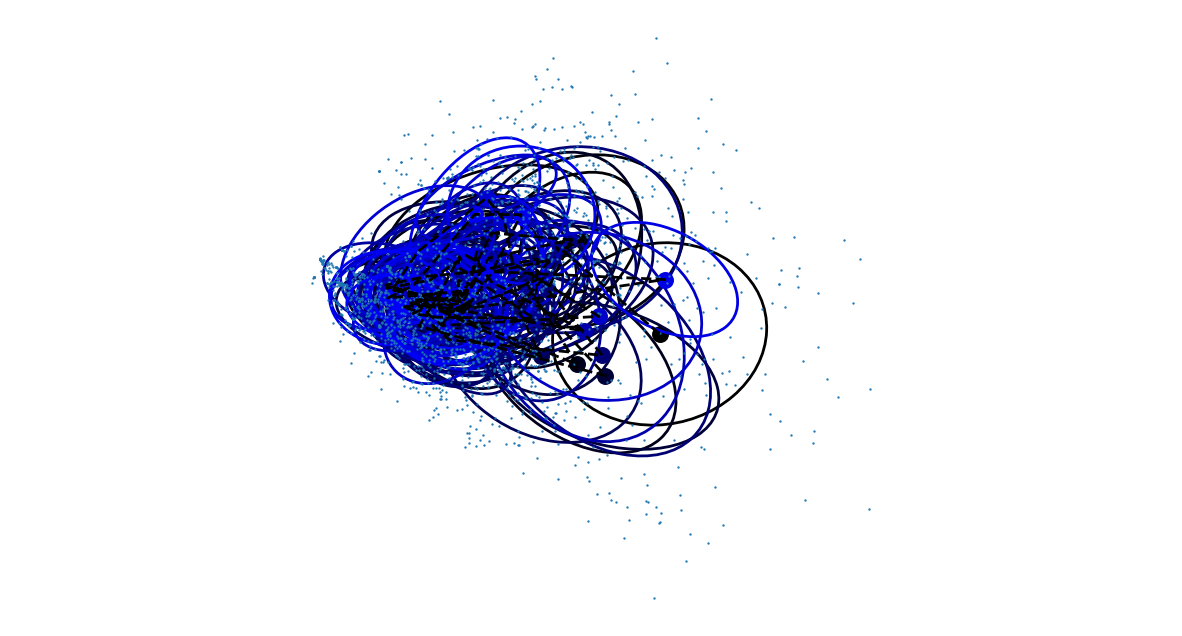

NameError: name 'joint' is not defined

In [44]:
# Needs Wishart installed and added to the path
# https://github.com/neurostatslab/wishart-process
path = '../../'
sys.path.insert(0,path+'wishart-process/')

import models
import inference
import utils
import evaluation
import visualizations

i = 1
x,y,r,c = xs[i],ys[i],rs[i],cs[i]

gp_kernel = utils.get_kernel(
    model_params['gp_kernel'],
    model_params['gp_kernel_diag']
)
D = y.shape[2]

print('Trials, Conditions, Neurons: ', y.shape)


gp = models.GaussianProcess(kernel=gp_kernel,num_dims=D)
empirical = jnp.cov((y - y.mean(0)[None]).reshape(y.shape[0]*y.shape[1],y.shape[2]).T)

wp_kernel = utils.get_kernel(
    model_params['wp_kernel'],
    model_params['wp_kernel_diag']
)


V = empirical+model_params['wp_sample_diag']*jnp.eye(D)

wp = models.WishartLRDProcess(
    kernel=wp_kernel,nu=model_params['nu'] ,
    V=V,optimize_L=model_params['optimize_L'],
    diag_scale=model_params['wp_sample_diag']
)

likelihood = eval('models.'+model_params['likelihood'])(D)
joint = models.JointGaussianWishartProcess(gp,wp,likelihood) 

print(gp.evaluate_kernel(x,x).max())
print(wp.evaluate_kernel(x,x).max())

compared = evaluation.compare(y)
compared['grand-empirical'] = jnp.repeat(empirical[:,:,None],y.shape[1],2)


# %%
mu_empirical = y.mean(0)
sigma_empirical = compared['empirical'].transpose(2,0,1)
visualizations.visualize_pc(
    mu_empirical[:,None],
    .1*sigma_empirical,
    pc=y.reshape(y.shape[0]*y.shape[1],-1),
    dotsize=500,
    linewidth=2,
    fontsize=30
)

# %%
init = {'G':y.mean(0).T[:,None]}

varfam = eval('inference.'+variational_params['guide'])(
    joint.model,init=init
)
optimizer = eval('optim.'+variational_params['optimizer']['type'])(
    variational_params['optimizer']['step_size']
)
key = jax.random.PRNGKey(seed)

varfam.infer(
    optimizer,x,y,
    n_iter=variational_params['n_iter'],key=key,
    num_particles=variational_params['num_particles']
)
joint.update_params(varfam.posterior)

In [ ]:
# %%
posterior = models.NormalGaussianWishartPosterior(joint,varfam,x)
with numpyro.handlers.seed(rng_seed=seed):
    mu_hat, sigma_hat, F_hat = posterior.mode(x)
    mu_prime, sigma_prime = posterior.derivative(x)
    log_pf, log_pg = posterior.posterior.log_prob(F=F_hat,G=mu_hat.T[:,None])

mus[index] = mu_hat.copy()
sigmas[index] = sigma_hat.copy()

# %%
visualizations.plot_loss(
    [varfam.losses],xlabel='Iteration',ylabel='ELBO',
    titlestr='Training Loss',colors=['k'],
)
# %%
visualizations.visualize_pc(
    mu_hat[:,None],.1*sigma_hat,
    pc_test=y_test.reshape(y_test.shape[0]*y_test.shape[1],-1),
    dotsize=500,
    linewidth=2,
    fontsize=30
)
# %%
var_bootstrap = jnp.array([jnp.concatenate((y[:i],y[i+1:])).var(0) for i in range(y.shape[0])])

# %%
visualizations.plot_variance_smoothness(
    x[:,None],[
        y.var(0),
        jnp.array([jnp.diag(compared['lw'][:,:,i]) for i in range(len(x))]),
        jnp.array([jnp.diag(compared['grand-empirical'][:,:,i]) for i in range(len(x))]),
        jnp.array([jnp.diag(sigma_hat[i]) for i in range(len(x))]),
    ],
    yerr=var_bootstrap,
    methods=['empirical','lw','grand-empirical','wishart']
)
# %%
compared['wishart'] = sigma_hat.transpose(1,2,0)
lpp = {}
mu_empirical = y.mean(0)

for key in compared.keys():
    lpp[key] = likelihood.log_prob(y_test,mu_empirical,compared[key].transpose(2,0,1)).flatten()


visualizations.plot_box(
    lpp,titlestr='Log Posterior Predictive',
)

[print(key, jnp.median(lpp[key])) for key in lpp.keys()]
print(jnp.median(jnp.exp(lpp['wishart']-lpp['grand-empirical'])))

In [ ]:
dist_neural = utils.ssd([
    [[mus[i],sigmas[i]], 
     [mus[j],sigmas[j]]]
     for i in range(len(ys)) 
     for j in range(len(ys))],
    alpha=2.,
    niter=1000
)

dist_rt = utils.ssd([
    [[rts[i].mean(0)[:,None], rts[i].var(0)[:,None,None]],
     [rts[j].mean(0)[:,None], rts[j].var(0)[:,None,None]]]
    for i in range(len(ys)) 
    for j in range(len(ys))],
    alpha=2.,
    niter=1000
)

dist_cc = utils.ssd([
    [[ccs[i].mean(0)[:,None], ccs[i].var(0)[:,None,None]],
     [ccs[j].mean(0)[:,None], ccs[j].var(0)[:,None,None]]]
    for i in range(len(ys)) 
    for j in range(len(ys))],
    alpha=2.,
    niter=1000
)
